#### Let's import the libraries

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.applications import resnet, inception_v3
import pandas as pd
import datetime, os
import shutil
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras import regularizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

keras.__version__

'2.4.0'

## Preprocessing
#### Create train and test set

In [2]:
dest_train = r"C:\Users\feder\Desktop\images_animals10_split\train"
dest_test = r"C:\Users\feder\Desktop\images_animals10_split\test"
dest_val = r"C:\Users\feder\Desktop\images_animals10_split\val" 

In [3]:
species = np.array(tf.io.gfile.listdir(str(dest_train)))
species = species[species != 'README.md']
n_classes= len(species)
print('Species:', species)

Species: ['buffalo' 'chimpanzee' 'deer' 'fox' 'horse' 'lion' 'moose' 'otter'
 'raccoon' 'sheep']


#### Defining imagedatagenerators

In [4]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet.preprocess_input,
                                                                shear_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                brightness_range=[0.5, 1.5])


train_generator = train_processing.flow_from_directory(directory = dest_train,
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1234)

Found 7749 images belonging to 10 classes.


In [5]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

val_generator = val_processing.flow_from_directory(
        directory=dest_val,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 964 images belonging to 10 classes.


In [6]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory=dest_test,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=False
)

Found 976 images belonging to 10 classes.


#### Let's define the weights for each class

In [7]:
dict_classes = {}
for class_el in os.listdir(dest_train):
    dict_classes[class_el] = len(os.listdir(f"{dest_train}/{class_el}"))

dict_classes

{'buffalo': 716,
 'chimpanzee': 582,
 'deer': 1075,
 'fox': 531,
 'horse': 1316,
 'lion': 815,
 'moose': 563,
 'otter': 606,
 'raccoon': 409,
 'sheep': 1136}

In [8]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 7749

weight_for_0 = (1 / 716)*(total)/10.0 
weight_for_1 = (1 / 582)*(total)/10.0
weight_for_2 = (1 / 1075)*(total)/10.0 
weight_for_3 = (1 / 532)*(total)/10.0
weight_for_4 = (1 / 1316)*(total)/10.0 
weight_for_5 = (1 / 815)*(total)/10.0
weight_for_6 = (1 / 563)*(total)/10.0 
weight_for_7 = (1 / 606)*(total)/10.0
weight_for_8 = (1 / 409)*(total)/10.0 
weight_for_9 = (1 / 1136)*(total)/10.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6, 7: weight_for_7, 8: weight_for_8, 9: weight_for_9}

## Modelling
#### Import ResNet

In [23]:
base_net = resnet.ResNet101(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3), pooling="avg")

In [24]:
for layer in base_net.layers:
    layer.trainable = False

#### Create our models as a combination of Resnet and other layers 

In [25]:
# Output of the base_net model
x = base_net.output
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(l2=0.0005))(x)
x = keras.layers.BatchNormalization()(x)
pred = keras.layers.Dense(10, activation='softmax')(x)

In [26]:
model = keras.Model(inputs=base_net.input, outputs=pred)

In [1]:
#model.summary()

#### Compile the model with Categorical crossentropy as loss, Adam as optimizer and accuracy as metric

In [29]:
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

## Training

In [30]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="bidim_weights",
                                              save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)

from tensorflow.keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    if epoch > 1:
        lr = 0.0005

    return lr

In [31]:
history1 = model.fit(train_generator,
          epochs=5,
          validation_data=val_generator,
          callbacks=[cp_callback, LearningRateScheduler(lr_scheduler, verbose=1)], class_weight=class_weight)
  

Epoch 1/5

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
243/243 [==============================] - 227s 905ms/step - loss: 0.7166 - accuracy: 0.8001 - val_loss: 0.2123 - val_accuracy: 0.9523

Epoch 00001: val_accuracy improved from -inf to 0.95228, saving model to bidim_weights
Epoch 2/5

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
243/243 [==============================] - 221s 908ms/step - loss: 0.2497 - accuracy: 0.9393 - val_loss: 0.1898 - val_accuracy: 0.9658

Epoch 00002: val_accuracy improved from 0.95228 to 0.96577, saving model to bidim_weights
Epoch 3/5

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
243/243 [==============================] - 223s 915ms/step - loss: 0.2118 - accuracy: 0.9517 - val_loss: 0.1804 - val_accuracy: 0.9689

Epoch 00003: val_accuracy improved from 0.96577 to 0.96888, saving model to bidim_weights
Epoch 4/5

Epoch 00004: LearningRateScheduler reducing 

In [17]:
load_status = net1.load_weights("bidim_weights")
load_status.assert_consumed()

## Results

In [42]:
# Confusion matrix
def c_matrix(y_val, y_pred, classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax= plt.subplots(figsize = (8,6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 10},
               linewidths=.2, fmt="d", cmap="PuBu")
    plt.xlabel("True Class", size = 12, horizontalalignment="right")
    plt.ylabel("Predicted Class", size = 12)
    ax.set_yticklabels(classes, rotation = 45, fontdict= {'fontsize': 10})
    ax.set_xticklabels(classes, rotation = 30, fontdict= {'fontsize': 10})
    plt.title("Confusion matrix", size = 20)
    plt.show()


Y_pred = model.predict_generator(test_generator, 976  // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
species = ['buffalo', 'chimpanzee', 'deer', 'fox', 'horse', 'lion', 'moose', 'otter',
 'raccoon', 'sheep']
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=species))

Classification Report
              precision    recall  f1-score   support

     buffalo       0.95      0.89      0.92        90
  chimpanzee       0.99      0.99      0.99        74
        deer       0.97      1.00      0.99       135
         fox       0.97      1.00      0.99        67
       horse       1.00      0.97      0.98       165
        lion       1.00      0.98      0.99       103
       moose       0.89      0.92      0.90        71
       otter       0.96      0.97      0.97        77
     raccoon       0.96      0.94      0.95        52
       sheep       0.97      1.00      0.98       142

    accuracy                           0.97       976
   macro avg       0.97      0.97      0.97       976
weighted avg       0.97      0.97      0.97       976



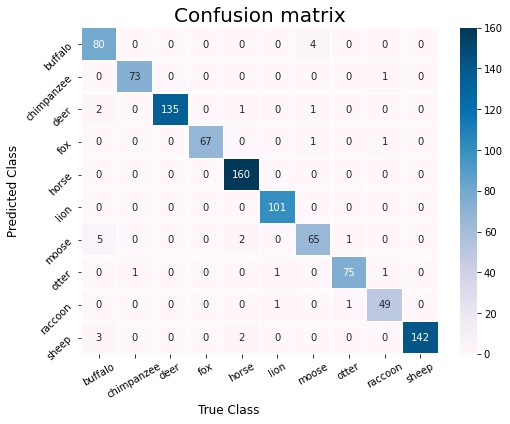

In [43]:
c_matrix(y_pred, test_generator.classes, species)

In [44]:
def accuracy_loss(history):
    plt.figure(figsize=(20,10))
    #
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = "train_accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="train_accuracy", color ="blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15)
    #
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Test loss", color = "blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15)

In [45]:
performance1 = net1.evaluate(test_generator)

31/31 [==============================] - 15s 465ms/step - loss: 0.1401 - accuracy: 0.9754


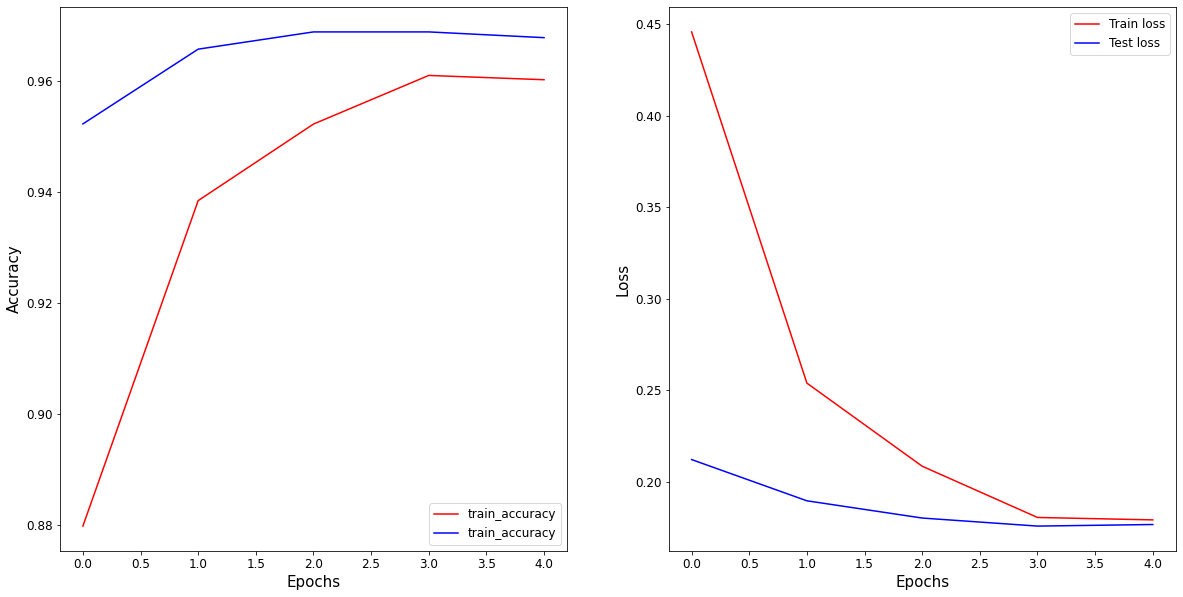

In [46]:
accuracy_loss(history1)